In [97]:
import sys,os

import pyglet
pyglet.options['shadow_window'] = True

import pyrender#to display mesh

import trimesh#to load mesh
import igl

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from sklearn.neighbors import KDTree

from ICP_functions import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
#Make obj files for each model.
ply_filenames=['bunny_v2/bun000_v2.obj','bunny_v2/bun045_v2.obj']
make_obj_test_files(ply_filenames)
n_models=len(ply_filenames)

In [99]:
#Render each model as a pointcloud.
colors=[(0.0,0.0,1.0),(0.0,1.0,0.0)]
file_paths=['M1.obj','M2.obj']
tms=[]
mesh_rds=[]
for i in range(n_models):
    fp=file_paths[i]
    tm = trimesh.load_mesh(fp)#load mesh
    surface_points = tm.sample(20000)#sample points for a point cloud
    mesh_rd = pyrender.Mesh.from_points(surface_points, colors[i])#make a point cloud object
    tms.append(tm)
    mesh_rds.append(mesh_rd)
    
show_mesh_gui(mesh_rds)#Display pointclouds.

In [103]:
#Select points to use for ICP. Better to use more points than I used for the renders.
#Can use either vertices, points sampled from the mesh.

#P=tms[0].sample(50000)
#Q=tms[1].sample(50000)
P,f_P=igl.read_triangle_mesh('M1.obj')
Q,f_Q=igl.read_triangle_mesh('M2.obj')


#Just usual ICP:
#R,t,mse_losses,iterations = ICP(P,Q,max_n=5,tol=1e-8)
#Just PTP ICP:
#total_R,total_t,mse_losses,iterations = point_to_plane_ICP(P,Q,max_n=100,tol=1e-8)
#Both:


R,t,mse_losses,iterations = ICP(P,Q,max_n=5,tol=1e-8)
Q = (R@Q.T).T + t.T
total_R,total_t,mse_lossesPTP,iterationsPTP = point_to_plane_ICP(P,Q,max_n=100,tol=1e-8)

ICP did not converge after 5 iterations.
ICP converged after 6 iterations.


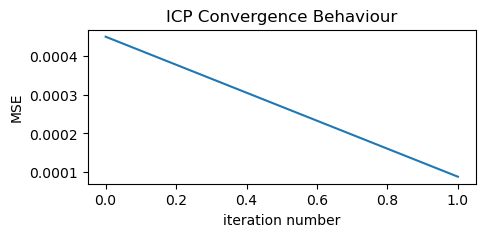

In [101]:
#Plot convergence behaviour.
fig,ax=plt.subplots(1,1,figsize=(5,2))
ax.plot(mse_losses)
ax.set_title('ICP Convergence Behaviour')
ax.set_xlabel('iteration number')
ax.set_ylabel('MSE')
plt.show()

In [ ]:
M2_v, M2_f = igl.read_triangle_mesh('M2.obj')#Get vertices and faces of M2.
initial_align_M2_v = (R@M2_v.T).T + t.T
realigned_M2_v = (total_R@(initial_align_M2_v.T)).T + total_t.T#Perform the transformation on M2.
ret=igl.write_triangle_mesh("initial_aligned_M2.obj", initial_align_M2_v,M2_f)#Save the aligned mesh.
ret=igl.write_triangle_mesh("aligned_M2.obj", realigned_M2_v,M2_f)#Save the aligned mesh.

#Render M1 and aligned version of M2 as pointclouds.
colors=[(0.0,0.0,1.0),(0.0,1.0,0.0),(1.0,0.0,0.0)]
file_paths=['M1.obj','aligned_M2.obj','initial_aligned_M2.obj']
tms=[]
mesh_rds=[]
surface_points_list=[]
for i in range(3):
    fp=file_paths[i]
    tm = trimesh.load_mesh(fp)#load mesh
    surface_points = tm.sample(20000)#sample points for a point cloud
    mesh_rd = pyrender.Mesh.from_points(surface_points, colors[i])#make a point cloud object
    tms.append(tm)
    mesh_rds.append(mesh_rd)
    surface_points_list.append(surface_points)
    
show_mesh_gui([mesh_rds[0],mesh_rds[1]])#Display pointclouds.
show_mesh_gui([mesh_rds[0],mesh_rds[2]])#Display pointclouds.

In [84]:
rd=render_from_obj('M1.obj')
show_mesh_gui([rd])
